In [5]:
from functools import partial
from typing import List, Optional, Union
import sys
sys.path.append('..')
import einops
import numpy as np
import plotly.express as px
import plotly.io as pio
import torch
from fancy_einsum import einsum
from IPython.display import HTML, IFrame
from jaxtyping import Float
import sys
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import transformers
import seaborn as sns
import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer, SVDInterpreter
torch.set_grad_enabled(False)
print("Disabled automatic differentiation")
plt.rcParams['font.sans-serif']=['Times New Roman']

Disabled automatic differentiation


In [32]:
def decode_tokens(tokenizer, token_array):
    if hasattr(token_array, "shape") and len(token_array.shape) > 1:
        return [decode_tokens(tokenizer, row) for row in token_array]
    return [tokenizer.decode([t]) for t in token_array]
def find_sublist_index(main_list, sub_list):
    main_list = main_list.tolist()
    sub_list = sub_list.tolist()
    index = main_list.index(sub_list[0])
    return (index, index+len(sub_list))
def check_subrange(tokens,sublist,range):
    subtokens = tokens[range[0]:range[1]]
    assert len(sublist) == len(subtokens)
    for x,y in zip(sublist,subtokens):
        if x==y:
            continue
        else:
            return False
    return True
def find_token_range(tokenizer, token_array, substring):
    toks = decode_tokens(tokenizer, token_array)
    whole_string = "".join(toks)
    char_loc = whole_string.index(substring)
    loc = 0
    tok_start, tok_end = None, None
    for i, t in enumerate(toks):
        loc += len(t)
        if tok_start is None and loc > char_loc:
            tok_start = i
        if tok_end is None and loc >= char_loc + len(substring):
            tok_end = i + 1
            break
    return (tok_start, tok_end)
class ComponentAnalyzer:
    def __init__(self, model, prompt,answer,subject) -> None:
        # List of prompts
        self.prompts = [prompt]
        # print(prompt)
        tokens = model.to_tokens(self.prompts, prepend_bos=True)
        str_tokens = model.to_str_tokens(self.prompts, prepend_bos=True)
        self.tokens = tokens
        self.str_tokens = str_tokens
        if 'llama' in model.cfg.model_name:
            subject_range = find_sublist_index(tokens[0], model.to_tokens(subject, prepend_bos=False)[0])
            assert check_subrange(tokens[0], model.to_tokens(subject, prepend_bos=False)[0],subject_range)
        else:
            subject_range = find_token_range(model.tokenizer, tokens[0],subject)
        # List of answers, in the format (correct, incorrect)
        self.answer_token = model.to_tokens(answer, prepend_bos=False)[0][0]
        self.subject_range = subject_range
        # self.subject_pos = subject_range[-1]-1
        self.subject_last_token = tokens[0][subject_range[-1]-1]
        self.logits,self.cache = model.run_with_cache(tokens)
        self.accum_resid, self.labels = self.cache.accumulated_resid(incl_mid=False,mlp_input=True,return_labels=True, apply_ln=True)
        self.heads_out = self.get_heads_out(model)
        self.mlp_out = self.get_mlp_out(model)
    def get_min_rank_at_subject(self, W_U, token_num):
        last_token_accum = self.accum_resid[:, 0, self.subject_range[0]:self.subject_range[1], :] 
        layers_unembedded = einsum(
                "layer ... d_model, d_model d_vocab -> layer ... d_vocab",
                last_token_accum,
                W_U,
            )
        sorted_indices = torch.argsort(layers_unembedded, dim=2, descending=True)
        rank_answer = (sorted_indices == token_num).nonzero(as_tuple=True)[2].view(layers_unembedded.size(0),-1)
        return rank_answer.min(dim=-1)[0]
    
    def get_token_rank(self, W_U, token_num, pos=-1):
        last_token_accum = self.accum_resid[:, 0, pos, :] 
        layers_unembedded = einsum(
                "layer d_model, d_model d_vocab -> layer d_vocab",
                last_token_accum,
                W_U,
            )
        sorted_indices = torch.argsort(layers_unembedded, dim=1, descending=True)
        rank_answer = (sorted_indices == token_num).nonzero(as_tuple=True)[1]
        return rank_answer
    def get_token_logits(self,model,tokens,pos=-1):
        answer_residual_directions = model.tokens_to_residual_directions(tokens)
        # print("Answer residual directions shape:", answer_residual_directions.shape)
        logit_diff_directions = (
            answer_residual_directions[:, ]
        )
        if len(logit_diff_directions.shape) ==1:
            logit_diff_directions = logit_diff_directions.unsqueeze(0)
        scaled_residual_stack = self.cache.apply_ln_to_stack(
                self.accum_resid, layer=-1, pos_slice=-1
            )
        # print(scaled_residual_stack.shape)
        return einsum(
                "... batch d_model, batch d_model -> ...",
                scaled_residual_stack,
                logit_diff_directions,
            )
    def get_token_probability(self,model,tokens,pos=-1):
        last_token_accum = self.accum_resid[:, 0, pos, :] 
        layers_unembedded = einsum(
                "layer d_model, d_model d_vocab -> layer d_vocab",
                last_token_accum,
                model.W_U,
            )
        probs = layers_unembedded.softmax(dim=-1)
        # print(scaled_residual_stack.shape)
        return probs[:,tokens]
    def get_heads_out(self, model,pos_slice=-1):
        per_head_residual, labels = self.cache.stack_head_results(
            layer=-1, pos_slice=pos_slice, return_labels=True, apply_ln=True
        )
        heads_out = {}
        for index, label in enumerate(labels):
            # Set the label
            layer = index // model.cfg.n_heads
            head_index = index % model.cfg.n_heads
            assert f"L{layer}H{head_index}"==label
            heads_out[label] = per_head_residual[index,:]
        return heads_out
    def get_mlp_out(self,model,pos_slice=-1):
        per_layer_residual, labels = self.cache.decompose_resid(
            mode='mlp',layer=-1, pos_slice=-1, return_labels=True,apply_ln= True
        )
        mlp_out= {}
        for x,y in zip(per_layer_residual, labels):
            mlp_out[y] = x
        return mlp_out
    def get_component_logits(self, output, model):
        # print(heads_out[head_name].shape)
        layers_unembedded = einsum(
                " ... d_model, d_model d_vocab -> ... d_vocab",
                output,
                model.W_U,
            )
        sorted_indices = torch.argsort(layers_unembedded, dim=1, descending=True)
        temp_logits = layers_unembedded[0]
        tmp_sorted_indices = sorted_indices[0]
        for i in range(10):
            print(
                f"Top {i}th token. Logit: {temp_logits[tmp_sorted_indices[i]].item():5.2f} Token: |{model.to_string(tmp_sorted_indices[i])}|"
            )


In [25]:
def draw_output_pattern_with_text(component, model, top_k=10):
    layers_unembedded = einsum(
            " ... d_model, d_model d_vocab -> ... d_vocab",
            component,
            model.W_U,
        )
    sorted_indices  = torch.argsort(layers_unembedded, dim=1, descending=True)
    temp_logits = layers_unembedded[0]
    tmp_sorted_indices = sorted_indices[0]
    top_logits = []
    top_tokens = []
    for i in range(top_k):
        top_logits.append(temp_logits[tmp_sorted_indices[i]].item())
        top_tokens.append(model.to_string(tmp_sorted_indices[i]))
    top_logits = np.expand_dims(np.array(top_logits),axis=-1)
    top_tokens = np.expand_dims(np.array(top_tokens),axis=-1)
    # 设置图形大小
    plt.figure(figsize=(1.5, 6),dpi=300)
    # 使用seaborn绘制热力图
    sns.heatmap(top_logits, annot=top_tokens, fmt='', cmap='Blues', cbar=True,xticklabels=False, yticklabels=False)
    # 添加标签和标题
    # plt.xlabel('Tokens')
    # plt.ylabel('Logits')
    # plt.title('Top Tokens Logits Heatmap')
    plt.show()
def draw_attention_pattern(Component,model,layer,head_index):
    fig = px.imshow(
        Component.cache["attn", layer][0, head_index][1:, 1:].cpu().numpy(),
        title=f"{layer}.{head_index} Attention",
        color_continuous_midpoint=0,
        color_continuous_scale="RdBu",
        labels={"y": "Queries", "x": "Keys"},
        height=500,
    )

    fig.update_layout(
        xaxis={
            "side": "top",
            "ticktext": Component.str_tokens[0][1:],
            "tickvals": list(range(len(Component.tokens[0])-1)),
            "tickfont": dict(size=15),
        },
        yaxis={
            "ticktext": Component.str_tokens[0][1:],
            "tickvals": list(range(len(Component.tokens[0])-1)),
            "tickfont": dict(size=15),
        },
    )
    # fig.write_image(f"{layer}.{head_index}_Attention.pdf")
    fig.show()
def draw_rank_logits(gpt2_medium, China):
    x=np.arange(gpt2_medium.cfg.n_layers+1)
    fig=plt.figure(figsize=(8,4),dpi=100)
    y1= China.get_token_rank(gpt2_medium.W_U,China.answer_token,pos=-1).cpu(),
    y1=utils.to_numpy(y1)[0]
    y2= China.get_token_probability(gpt2_medium,China.answer_token,pos=-1).squeeze(-1).cpu()
    y4= China.get_token_probability(gpt2_medium,China.subject_last_token,pos=-1).squeeze(-1).cpu()
    y2=utils.to_numpy(y2)
    # y3= China.get_token_rank(gpt2_medium.W_U,gpt2_medium.to_single_token(' Malaysian'),pos=-1).cpu()
    y3 = China.get_min_rank_at_subject(gpt2_medium.W_U,China.answer_token).cpu()
    y3=utils.to_numpy(y3)
    #ax1显示y1  ,ax2显示y2 
    ax1=fig.subplots()
    ax1.plot(x, y1, 'g-', label='Target Entity at Last Position')
    ax1.plot(x, y3, 'r-', label='Target Entity at Subject Position')
    # ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.set_ylim([0, 1])
    ax2.plot(x, y2, 'b--', label='Prob of Object Entity')
    ax2.plot(x, y4, 'g--', label='Prob of Subject Entity')

    ax1.set_xticks(np.arange(0, 24))
    ax1.set_xlabel('layer')
    ax1.set_yscale('log')
    ax1.set_ylabel('rank')
    ax2.set_ylabel('logits')

    # 添加图例
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()

## Load Model

In [8]:
device = "cuda:4"
# NBVAL_IGNORE_OUTPUT
gpt2_medium = HookedTransformer.from_pretrained(
    model_name= "gpt2-medium",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    device=device,
    refactor_factored_attn_matrices=True,
)

gpt2_medium = HookedTransformer.from_pretrained(
    model_name= "tinyllama",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    device=device,
    refactor_factored_attn_matrices=True,
)
# Get the default device used

Loaded pretrained model gpt2-medium into HookedTransformer


In [ ]:
tinyllama_path = 'path_to_checkpoint_of_tinyllama'
hf_model = transformers.AutoModelForCausalLM.from_pretrained(tinyllama_path)
tokenizer = transformers.AutoTokenizer.from_pretrained(tinyllama_path)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

model = HookedTransformer.from_pretrained(
    model_name= "tinyllama",
    hf_model=hf_model, 
    tokenizer=tokenizer,
    local_path=tinyllama_path,
    center_unembed=False,
    center_writing_weights=False,
    fold_ln=True,
    device=device,
)

In [33]:
China = ComponentAnalyzer(gpt2_medium,'The official language of France is',' French','France')
# China.get_min_rank_at_subject(gpt2_medium.W_U, China.answer_token)

Tried to stack head results when they weren't cached. Computing head results now


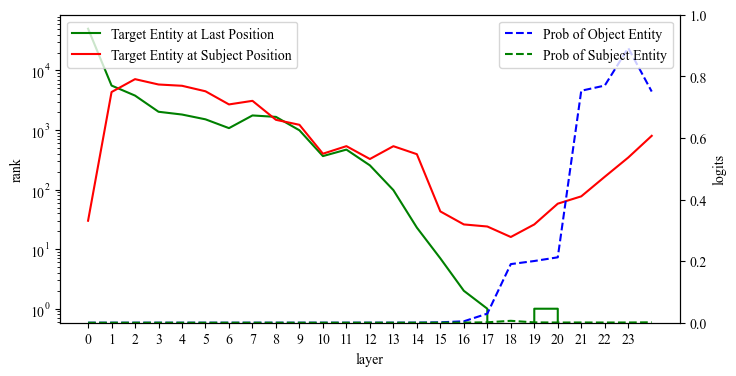

In [27]:
draw_rank_logits(gpt2_medium,China)

In [30]:
draw_attention_pattern(China,gpt2_medium,20,6)

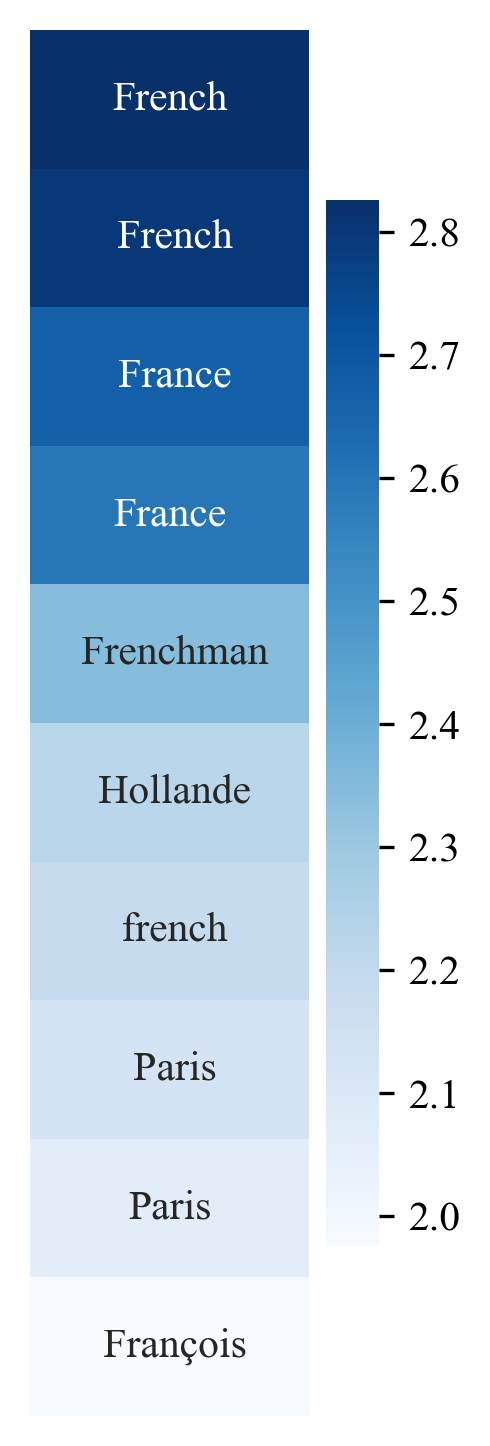

In [29]:
draw_output_pattern_with_text(China.heads_out['L20H6'],gpt2_medium,10)